main_project_real_data_007
refinePC
cell[12]
normalized_dataset_dict

 

In [1]:
import importlib.util

package_name = 'trimesh'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install trimesh
else:
    print(package_name +" is installed")

trimesh is installed


In [2]:
package_name = 'mahotas'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install mahotas
else:
    print(package_name +" is installed")

mahotas is installed


In [3]:
import numpy as np
import math
import cv2
import os
import pandas as pd
import mahotas
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import regionprops
from skimage.transform import rescale, resize
from skimage.morphology import thin
from skimage.morphology import skeletonize
from skimage.morphology import medial_axis
from matplotlib.ticker import MultipleLocator
from utils import dataset_loader, my_utils, Operations, Moments, generate_point_cloud
import warnings
warnings.filterwarnings('ignore')

from plyfile import PlyData, PlyElement

In [8]:
%matplotlib inline

# Present the Fig 1

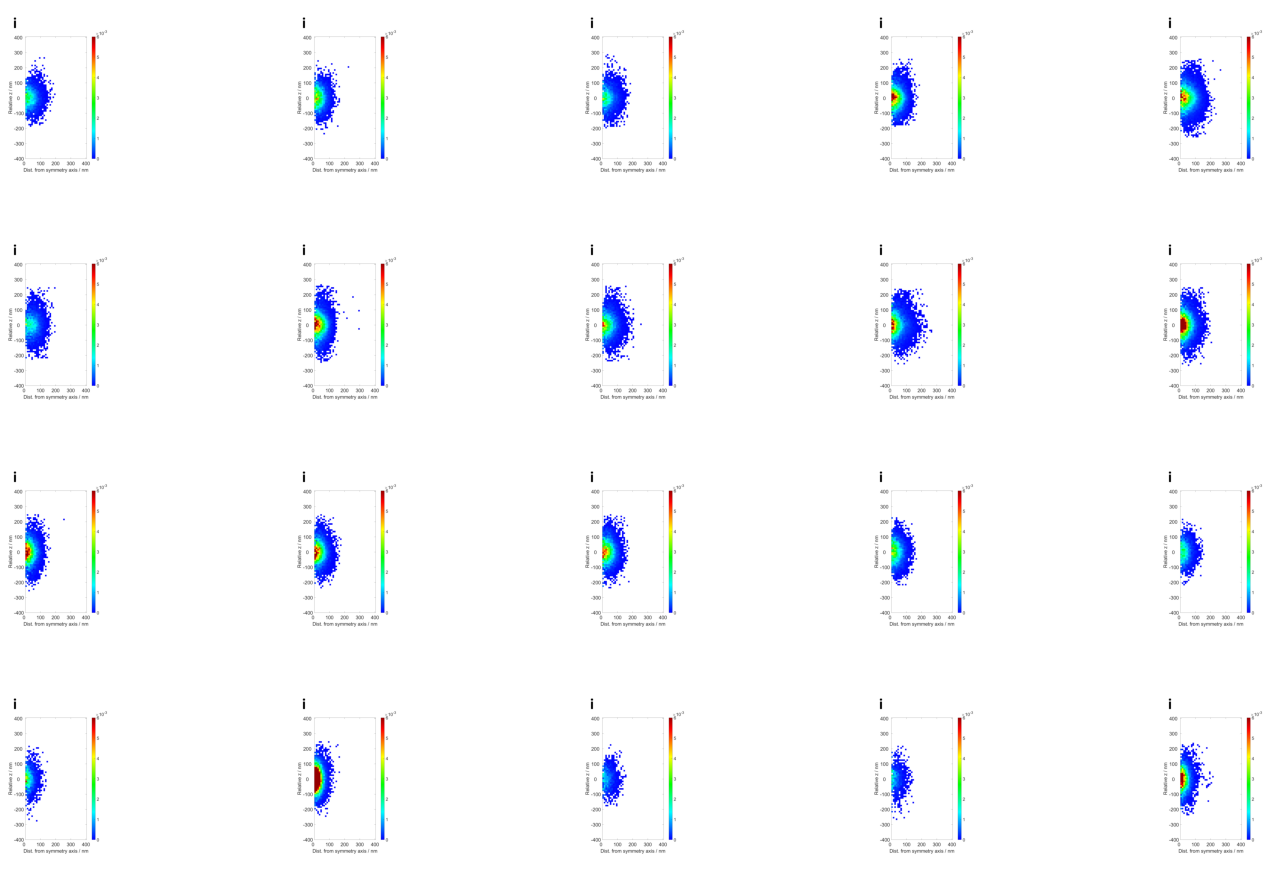

In [11]:

#https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [25, 16]
fig_den, axs = plt.subplots(4,5, sharey=True)
temperature = 53
# sample_index = 15
available_temperature = [21, 33, 35, 38, 43, 53]
# 
for sample_index in range(20):
    temp_C = str(temperature)+'C'
    img_visual_file = "/home/students/yiwei/Documents/Microgel/visualization/"+str(temperature)+"/real_"+temp_C+"_"+str(sample_index+1)+"_2d-density-distr.png"
    # img = mpimg.imread('/home/students/yiwei/Documents/Microgel/visualization/21/real_21C_1_2d-density-distr.png')
    img = mpimg.imread(img_visual_file)


    # fig_den = plt.figure(figsize=(55,5))
    row_i = sample_index//5
    col_i = sample_index%5
    axs[row_i,col_i].imshow(img)
    axs[row_i,col_i].get_xaxis().set_visible(False)
    axs[row_i,col_i].get_yaxis().set_visible(False)
    axs[row_i,col_i].axis('off')
    #     imgplot.savefig(outputname)
    # fig_density = plt.figure(figsize=(25,5))
    # ax1        = fig_density.add_subplot(1, 5, 1)

    # plt.show()   

# Load the samples

In [ ]:
DATA_DIR    = "/home/students/yiwei/Documents/PAINT_DiffTemp/Core-shell"
temperature = 21
sample_index = 15
available_temperature = [21, 33, 35, 38, 43, 53]
temp_C = str(temperature)+'C'


index_3d = str(sample_index)+".3d"
file = os.path.join(DATA_DIR,temp_C,"Microgel_plotter_v2_solvatochromism",index_3d)
print(file)

DATA = pd.read_csv(file, delimiter = "\t", header=None)
DATA = DATA.to_numpy()[:,:3]#only extract the location information
DATA[:,2] = 1-DATA[:,2]
# print(type(DATA))
print("The number of points in the pc: {}".format(DATA.shape[0]))

# Refine PC

In [ ]:
def refine_pc(DATA, lower_bound, upper_bound):
    sample_per_class = 1
    confidence = 0.99
    colors = ['g', 'b', 'k', 'y', 'm', 'c']
    do_normalize = True

    processed_points = []      
    points  = DATA
    # print(type(DATA))
    # print(type(points))
    # print('points',points )
    fig = plt.figure(figsize=(25,5))
    if do_normalize:
        Inlaier_points = []
        mue            = my_utils.calc_mue(points)# cal mean of a point cloud
    #     print(mue.shape)
    #     print('mue', mue)
        sorted_dists   = sorted([my_utils.calc_dist(p, mue) for p in points])
        XY             = [(0, 0)]
        t              = len(sorted_dists)
        for j, d in enumerate(sorted_dists):
            XY.append(( d, 1.*j/t ))
            if 1.*j/t >= confidence:
                break
        sorted_idx     = sorted([(i, my_utils.calc_dist(p, mue)) for i, p in enumerate(points)], key= lambda d:(d[1], d[0]))
        inlaier        = [d[0] for d in sorted_idx[:j]]
        inlaier_points = [points[j] for j in inlaier]
        points         = np.array(inlaier_points)
    #     print(points.shape)
        points        -= mue

        DATA = points
        
        mue            = np.mean(points, axis=0)

        ax1        = fig.add_subplot(1, sample_per_class, 1, projection="3d")
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, c=colors[1],marker="s", facecolor="red", lw=0, alpha=1)
        ax1.scatter(mue[0], mue[1], mue[2], s=100, c='r', marker="*")
        ax1.set_xlabel('x / nm')
        ax1.set_ylabel('y / nm')
        ax1.set_zlabel('z / nm')
        ax1.set_xlim((lower_bound,upper_bound))
        ax1.set_ylim((lower_bound,upper_bound))
        ax1.set_zlim((lower_bound,upper_bound))
        #ax1.set_title('Normalized PC '+temp_C+'-Sample '+str(sample_index))
        plt.show()
        return points

    # fig.savefig(temp_C+ '_'+str(sample_index) + '_3d.pdf', bbox_inches='tight')
    # fig.savefig(ply_type[1]+str(index) + '_3d.pdf', bbox_inches='tight')

In [ ]:
DATA = refine_pc(DATA, -300, 300)